## Data Understanding and Exploration

In [8]:
#Importing Neceessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

#### Data Loading and Visualization:

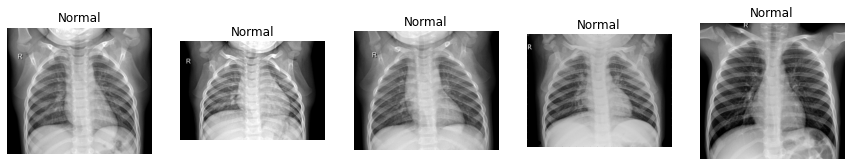

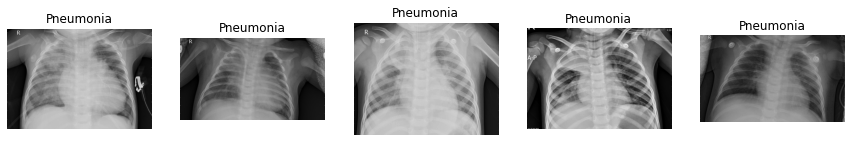

In [2]:
# Paths to our datasets
train_normal_dir = 'chest_xray/train/NORMAL'
train_pneumonia_dir = 'chest_xray/train/PNEUMONIA'

# Displaying some images samples from each class
def display_images_from_folder(folder, title, num=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(os.listdir(folder)[:num]):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Displaying images
display_images_from_folder(train_normal_dir, 'Normal')
display_images_from_folder(train_pneumonia_dir, 'Pneumonia')


Let's check the distribution of image dimensions and store their dimensions.

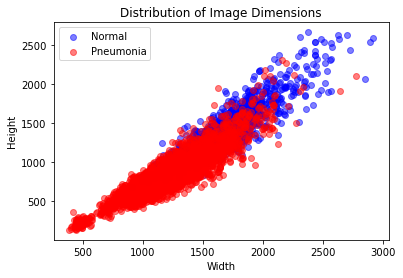

In [3]:
def get_image_dimensions(folder):
    dims = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            dims.append(img.size)
        except (UnidentifiedImageError, IsADirectoryError):
            continue
    return dims

# Getting dimensions
normal_dims = get_image_dimensions(train_normal_dir)
pneumonia_dims = get_image_dimensions(train_pneumonia_dir)

# Plotting
widths, heights = zip(*normal_dims)
plt.scatter(widths, heights, color='blue', label='Normal', alpha=0.5)
widths, heights = zip(*pneumonia_dims)
plt.scatter(widths, heights, color='red', label='Pneumonia', alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

From the scatter plot of image dimensions, it's evident that there's a variation in the sizes of the images across both 'Normal' and 'Pneumonia' classes. This variation in dimensions can be seen from the distinct clusters formed by the two classes, with a noticeable overlap. 

#### Class Distribution

Let's visualize the number of images in each class in the training data using a bar chart.

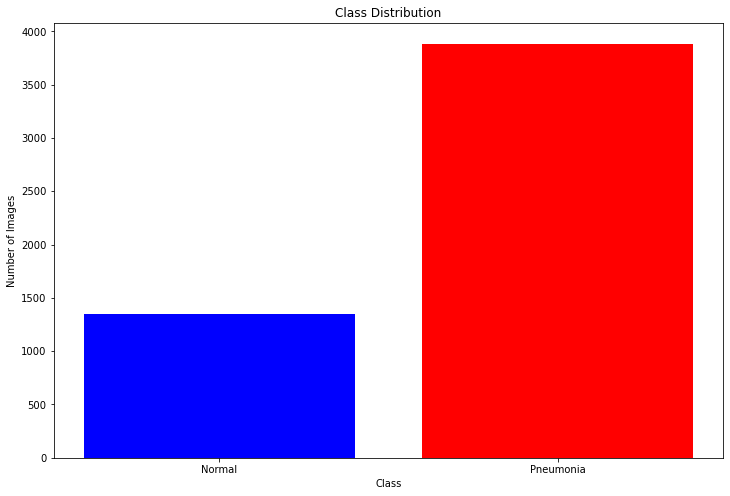

In [34]:
num_normal = len(os.listdir(train_normal_dir))
num_pneumonia = len(os.listdir(train_pneumonia_dir))

colors = ['blue', 'red']

plt.figure(figsize=(12, 8))

plt.bar(['Normal', 'Pneumonia'], [num_normal, num_pneumonia], color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

In [32]:
## Printing the number of images per class
print(f"Number of Normal images: {num_normal}")
print(f"Number of Pneumonia images: {num_pneumonia}")

Number of Normal images: 1349
Number of Pneumonia images: 3884


There is a significant class imbalance in the dataset. There are 1,349 images labeled as 'Normal' and a much larger set of 3,884 images labeled as 'Pneumonia'. Such an imbalance can lead to a model that is biased towards the 'Pneumonia' class, as it might prioritize accuracy for the majority class. To address this, we will use data augmentation to artificially increase the number of 'Normal' images. 

### Data Preprocessing

#### Resizing Images

Given the variation in our dataset's image dimensions, as observed earlier, resizing becomes a crucial preprocessing step to ensure our data is well-suited for modeling.

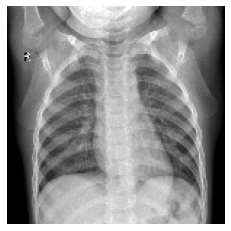

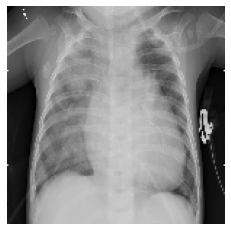

In [6]:
# Resizing the images to a standard size
def resize_images(folder, size=(150, 150)):
    resized_images = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = load_img(img_path, target_size=size)
            img_array = img_to_array(img)
            resized_images.append(img_array)
        except (UnidentifiedImageError, IsADirectoryError):
            continue
    return np.array(resized_images)

resized_normal_images = resize_images(train_normal_dir)
resized_pneumonia_images = resize_images(train_pneumonia_dir)

# Displaying a sample resized normal image
plt.imshow(resized_normal_images[0].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

# Displaying a sample resized pneumonia image
plt.imshow(resized_pneumonia_images[0].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

By standardizing the image dimensions, we ensure that our dataset is compatible with the neural network's architecture. The chosen size of 150x150 pixels is a balance between retaining sufficient detail for the model to discern patterns and ensuring computational efficiency. The image x-ray above showcases a sample after the resizing process.

#### Data Augmentation

Given the class imbalance, we will use data augmentation to artificially enhance the dataset, especially for the 'Normal' class. 

In [11]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [12]:
# Checking the number of resized normal images
num_resized_normal = len(resized_normal_images)

# Checking the number of augmented normal images
num_augmented_normal = num_resized_normal * 3  

print(f"Number of Resized Normal images: {num_resized_normal}")
print(f"Number of Augmented Normal images: {num_augmented_normal}")

Number of Resized Normal images: 1349
Number of Augmented Normal images: 4047


#### Saving the Augmented Data

In [13]:
augmented_dir = 'chest_xray/train/AUGMENTED_NORMAL'
if not os.path.exists(augmented_dir):
    os.mkdir(augmented_dir)

In [14]:
i = 0
for img_array in resized_normal_images:
    img_array = img_array.reshape((1,) + img_array.shape)
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_format='jpeg', save_prefix='aug'):
        i += 1
        if i >= num_augmented_normal:  
            break

In [15]:
augmented_normal_images = resize_images(augmented_dir)

In [16]:
all_normal_images = np.vstack((resized_normal_images, augmented_normal_images))
all_pneumonia_images = resized_pneumonia_images

#### Pixels Values Normalization.

In [17]:
all_normal_images = all_normal_images.astype('float32') / 255.0
all_pneumonia_images = all_pneumonia_images.astype('float32') / 255.0

The normalize_images function scales the pixel values of the images in the dataset to a range of [0.0, 1.0] by dividing each pixel value by 255.0. This normalization process is a standard preprocessing step in deep learning tasks, ensuring that the pixel values are within a consistent and manageable range for neural network training.

#### Splitting Data

In [18]:
X = np.vstack((all_normal_images, all_pneumonia_images))
y = np.array([0] * len(all_normal_images) + [1] * len(all_pneumonia_images))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Model Building

#### Simple Dense Network

In [135]:
simple_model_1 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')  
])

# Compile the model
simple_model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# Summarize the model architecture
simple_model_1.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8640128   
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 8,648,449
Trainable params: 8,648,449
Non-trainable params: 0
_________________________________________________________________


In [125]:
history_simple_1 = simple_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,  # Or any other number of epochs you'd like
    batch_size=32
)


Epoch 1/25
235/235 [==============================] - 9s 39ms/step - loss: 1.0586 - accuracy: 0.8601 - precision: 0.8355 - recall: 0.8242 - auc: 0.8761 - val_loss: 0.1024 - val_accuracy: 0.9670 - val_precision: 0.9430 - val_recall: 0.9794 - val_auc: 0.9945
Epoch 2/25
235/235 [==============================] - 9s 36ms/step - loss: 0.1504 - accuracy: 0.9505 - precision: 0.9329 - recall: 0.9485 - auc: 0.9853 - val_loss: 0.0709 - val_accuracy: 0.9744 - val_precision: 0.9655 - val_recall: 0.9730 - val_auc: 0.9969
Epoch 3/25
235/235 [==============================] - 9s 38ms/step - loss: 0.1358 - accuracy: 0.9540 - precision: 0.9367 - recall: 0.9533 - auc: 0.9870 - val_loss: 0.1610 - val_accuracy: 0.9318 - val_precision: 0.8769 - val_recall: 0.9717 - val_auc: 0.9838
Epoch 4/25
235/235 [==============================] - 9s 38ms/step - loss: 0.1108 - accuracy: 0.9619 - precision: 0.9428 - recall: 0.9665 - auc: 0.9904 - val_loss: 0.0628 - val_accuracy: 0.9792 - val_precision: 0.9613 - val_recal

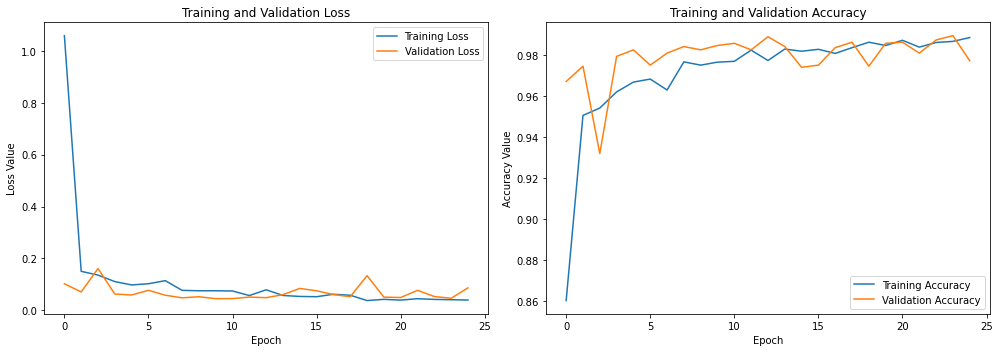

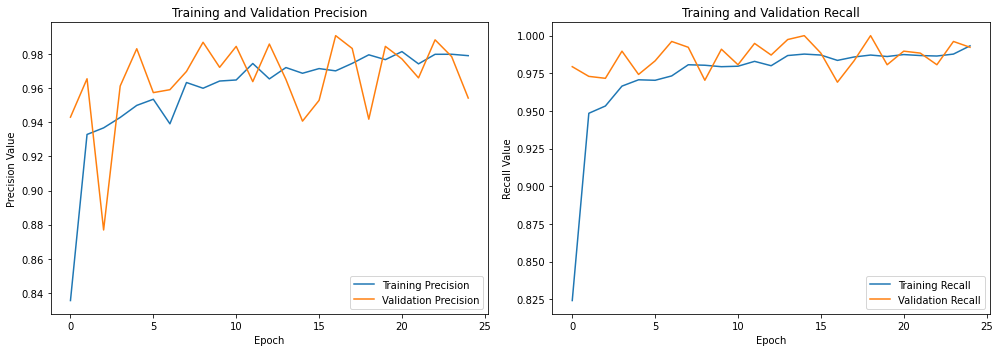

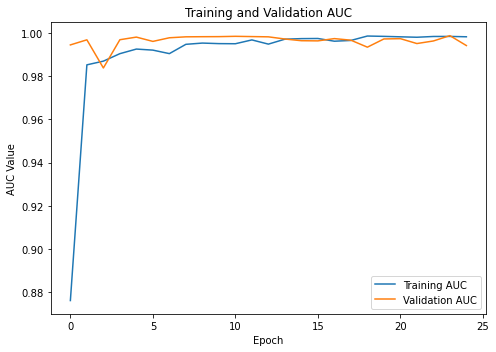

In [131]:
import matplotlib.pyplot as plt

# Retrieve the history data
history_data = history_simple_1.history

# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data['precision'], label='Training Precision')
plt.plot(history_data['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision Value')
plt.legend()

# Plot Recall
plt.subplot(1, 2, 2)
plt.plot(history_data['recall'], label='Training Recall')
plt.plot(history_data['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(7, 5))
plt.plot(history_data['auc'], label='Training AUC')
plt.plot(history_data['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Value')
plt.legend()

plt.tight_layout()
plt.show()


In [130]:
# Predict probabilities for the validation dataset
y_pred_probs = simple_model_1.predict(X_val)

# Convert probabilities to binary labels
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)


[[1064   37]
 [   6  771]]


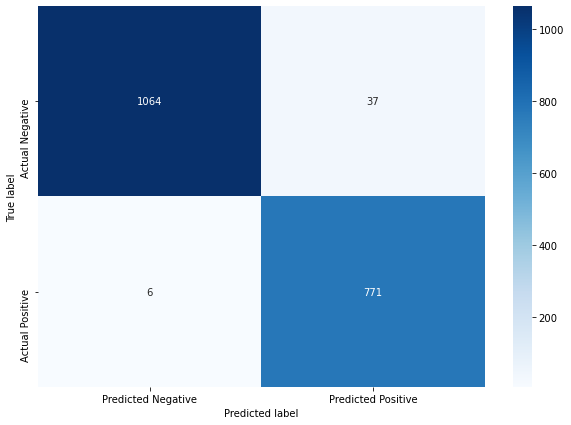

In [134]:
y_val_pred_probs = simple_model_1.predict(X_val)
y_val_preds = (y_val_pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model correctly identified 771 cases as pneumonia (True Positives) and 1064 cases as not having pneumonia (True Negatives). However, it incorrectly classified 37 cases as having pneumonia when they did not (False Positives) and missed 6 actual pneumonia cases by predicting them as negative (False Negatives). With an impressive accuracy of 97.71%, a precision of 95.42% that indicates the reliability of a positive diagnosis, and an exceptionally high recall of 99.23% highlighting the model's ability to capture the majority of actual pneumonia cases, the diagnostic tool exhibits robust performance in this classification task.

#### Dense Network with Increased Complexity

After experimenting with a basic dense network, it's natural to explore how increasing the complexity of the model impacts its performance. By adding more layers and neurons, we're allowing the network to potentially learn more intricate patterns in the data. We will incrementally scale up the complexity of our dense neural network, evaluating its performance at each step, and observing the trade-offs involved.

In [78]:
model_complex = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),  # Adding another Dense layer with more neurons
    Dense(2048, activation='relu'),  # Another Dense layer with even more neurons
    Dense(1, activation='sigmoid')
])

model_complex.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [79]:
history_complex = model_complex.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/25
235/235 [==============================] - 42s 181ms/step - loss: 0.8674 - accuracy: 0.8978 - val_loss: 0.2278 - val_accuracy: 0.9121
Epoch 2/25
235/235 [==============================] - 43s 183ms/step - loss: 0.0935 - accuracy: 0.9672 - val_loss: 0.1355 - val_accuracy: 0.9622
Epoch 3/25
235/235 [==============================] - 42s 177ms/step - loss: 0.1129 - accuracy: 0.9651 - val_loss: 0.0526 - val_accuracy: 0.9846
Epoch 4/25
235/235 [==============================] - 42s 179ms/step - loss: 0.0656 - accuracy: 0.9778 - val_loss: 0.0955 - val_accuracy: 0.9739
Epoch 5/25
235/235 [==============================] - 41s 177ms/step - loss: 0.0582 - accuracy: 0.9798 - val_loss: 0.0481 - val_accuracy: 0.9862
Epoch 6/25
235/235 [==============================] - 42s 177ms/step - loss: 0.0777 - accuracy: 0.9760 - val_loss: 0.0519 - val_accuracy: 0.9856
Epoch 7/25
235/235 [==============================] - 40s 172ms/step - loss: 0.0726 - accuracy: 0.9762 - val_loss: 0.0684 - val_ac

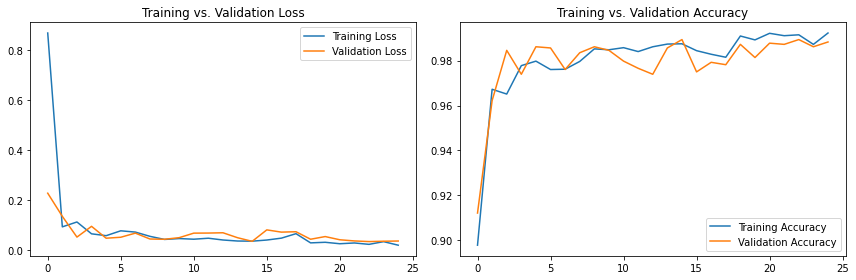

In [82]:
# Extracting training and validation data from 'history_complex'
train_loss = history_complex.history['loss']
val_loss = history_complex.history['val_loss']
train_acc = history_complex.history['accuracy']
val_acc = history_complex.history['val_accuracy']

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.tight_layout()
plt.show()


The Dense Network with Increased Complexity demonstrated impressive learning over 25 epochs, with training accuracy starting at 89.78% and surging to 99.23% by the end. Validation accuracy mirrored this trend, commencing at 91.21% and culminating at a commendable 98.83% by the final epoch. While this enhanced complexity has yielded improved performance in recognizing patterns and generalizing to unseen data, occasional fluctuations in validation loss and instances where training accuracy outpaced validation accuracy highlight the need for vigilance against potential overfitting in subsequent iterations.

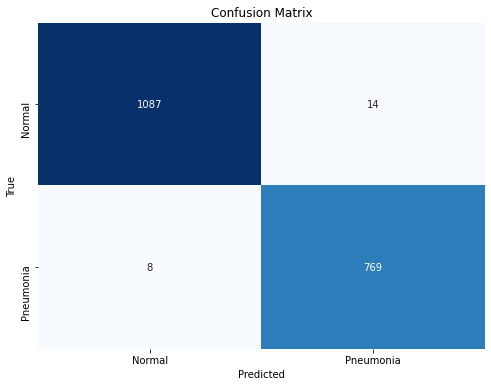

In [85]:
# Making Predictions
y_pred = model_complex.predict(X_val)

# Converting predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculating Confusion Matrix
confusion_mat = confusion_matrix(y_val, y_pred_binary)

# Creating the Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix reveals that the Dense Network with Increased Complexity model achieved a high number of True Negatives (1087), indicating its proficiency in correctly identifying cases where patient has no pneumonia. However, there were some instances of False Positives (14), where the model incorrectly predicted pneumonia when it was not present. Additionally, there were a few False Negatives (8), signifying cases where the model missed actual instances of pneumonia. Nevertheless, the model performed well in identifying positive cases, with a substantial count of True Positives (769).

#### Combining Regularization and Dropout

As we delve deeper into optimizing neural networks, overfitting becomes a prominent challenge. This occurs when our model, in its enthusiasm to minimize loss, starts to "memorize" the training data rather than genuinely "understanding" it. To combat this, we will integrate two powerful techniques: regularization and dropout.

In [83]:
# Defining regularization strength
reg_strength = 0.01

model_reg_dropout = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(512, activation='relu', kernel_regularizer=l2(reg_strength)),  # Applying L2 regularization
    Dropout(0.5),  # 50% dropout
    Dense(1024, activation='relu', kernel_regularizer=l2(reg_strength)),  # Applying L2 regularization
    Dropout(0.5),  # 50% dropout
    Dense(2048, activation='relu', kernel_regularizer=l2(reg_strength)),  # Applying L2 regularization
    Dropout(0.5),  # 50% dropout
    Dense(1, activation='sigmoid')
])

model_reg_dropout.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

history_reg_dropout = model_reg_dropout.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/25
235/235 [==============================] - 84s 356ms/step - loss: 16.0984 - accuracy: 0.7629 - val_loss: 9.4271 - val_accuracy: 0.9233
Epoch 2/25
235/235 [==============================] - 82s 350ms/step - loss: 7.6368 - accuracy: 0.7692 - val_loss: 6.4441 - val_accuracy: 0.5863
Epoch 3/25
235/235 [==============================] - 83s 354ms/step - loss: 4.9588 - accuracy: 0.7326 - val_loss: 3.9497 - val_accuracy: 0.8829
Epoch 4/25
235/235 [==============================] - 83s 352ms/step - loss: 3.4065 - accuracy: 0.6937 - val_loss: 2.6989 - val_accuracy: 0.8024
Epoch 5/25
235/235 [==============================] - 83s 354ms/step - loss: 2.3798 - accuracy: 0.6951 - val_loss: 1.8857 - val_accuracy: 0.8514
Epoch 6/25
235/235 [==============================] - 79s 337ms/step - loss: 1.7778 - accuracy: 0.6915 - val_loss: 1.5320 - val_accuracy: 0.9020
Epoch 7/25
235/235 [==============================] - 77s 329ms/step - loss: 1.3949 - accuracy: 0.6783 - val_loss: 1.2040 - val_a

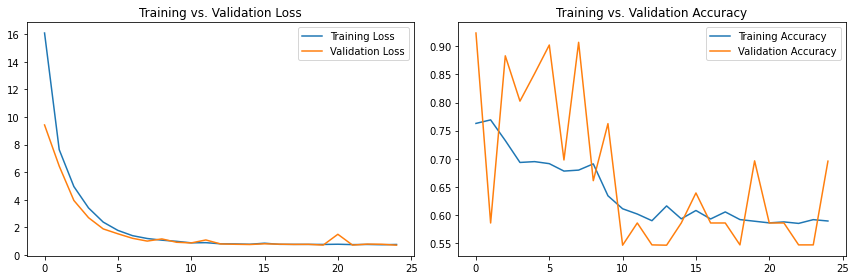

In [92]:
# Extracting training and validation data from 'history_reg_dropout'
train_loss = history_reg_dropout.history['loss']
val_loss = history_reg_dropout.history['val_loss']
train_acc = history_reg_dropout.history['accuracy']
val_acc = history_reg_dropout.history['val_accuracy']

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.tight_layout()
plt.show()


The model, which combined L2 regularization and dropout, showed significant fluctuations in both training and validation accuracy over 25 epochs. The starting accuracy was promising, but subsequent epochs revealed inconsistent performance. This could be attributed to a possibly strong regularization strength of 0.01 and a high dropout rate of 50%. These factors, coupled with the model's inherent complexity, might be causing it to underfit. While the techniques were introduced to combat overfitting, their aggressive application might be limiting the model's ability to learn from the data effectively. 

 #### Implementing Early Stopping

To address the observed overfitting in our simple model, we'll employ early stopping. This technique will halt training as soon as the validation loss begins to rise, preventing the model from over-optimizing on the training data and ensuring it generalizes well to unseen data.

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [67]:
history_simple = model_simple.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stop])

Epoch 1/25
235/235 [==============================] - 38s 163ms/step - loss: 0.0347 - accuracy: 0.9887 - val_loss: 0.0537 - val_accuracy: 0.9846
Epoch 2/25
235/235 [==============================] - 39s 166ms/step - loss: 0.0647 - accuracy: 0.9780 - val_loss: 0.0479 - val_accuracy: 0.9814
Epoch 3/25
235/235 [==============================] - 39s 167ms/step - loss: 0.0402 - accuracy: 0.9848 - val_loss: 0.0449 - val_accuracy: 0.9899
Epoch 4/25
235/235 [==============================] - 38s 161ms/step - loss: 0.0329 - accuracy: 0.9889 - val_loss: 0.0771 - val_accuracy: 0.9776
Epoch 5/25
235/235 [==============================] - 36s 154ms/step - loss: 0.0392 - accuracy: 0.9867 - val_loss: 0.0397 - val_accuracy: 0.9878
Epoch 6/25
235/235 [==============================] - 36s 153ms/step - loss: 0.0255 - accuracy: 0.9909 - val_loss: 0.0445 - val_accuracy: 0.9835
Epoch 7/25
235/235 [==============================] - 36s 154ms/step - loss: 0.0261 - accuracy: 0.9908 - val_loss: 0.0670 - val_ac

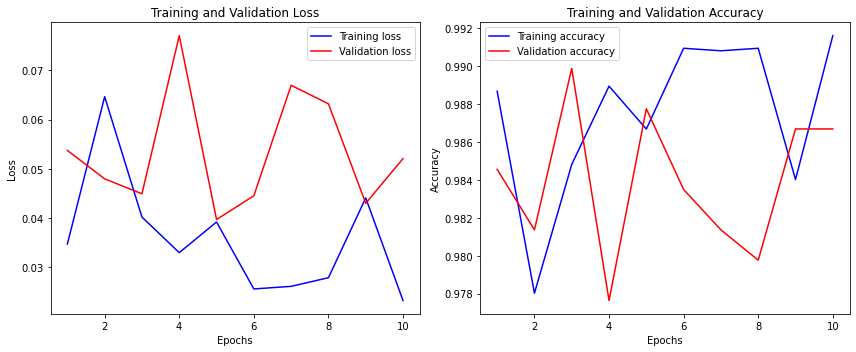

In [72]:
# Extract values from the history object
train_loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']
train_acc = history_simple.history['accuracy']
val_acc = history_simple.history['val_accuracy']

# Plotting
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The model was trained for a maximum of 25 epochs with early stopping enabled to monitor the validation loss. Beginning with a training accuracy of 98.87% and a validation accuracy of 98.46% in the first epoch, the model experienced fluctuations in both loss and accuracy throughout the training process. By the 5th epoch, the validation accuracy reached its peak at 98.78% with a corresponding validation loss of 0.0397. However, the model began to show signs of overfitting afterwards, as indicated by increasing validation losses in the subsequent epochs. Consequently, after the 10th epoch, where the training accuracy was 99.16% and the validation accuracy was 98.67%, the early stopping callback intervened, halting the training and restoring the model's weights to those from the best epoch to ensure optimal generalization to unseen data.

#### CNN

In [139]:
# CNN Architecture
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)     

In [140]:
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=25,
                            batch_size=32,
                            validation_data=(X_val, y_val))

Epoch 1/25
235/235 [==============================] - 106s 451ms/step - loss: 0.1361 - accuracy: 0.9409 - val_loss: 0.0536 - val_accuracy: 0.9835
Epoch 2/25
235/235 [==============================] - 104s 441ms/step - loss: 0.0375 - accuracy: 0.9856 - val_loss: 0.0495 - val_accuracy: 0.9883
Epoch 3/25
235/235 [==============================] - 108s 461ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0266 - val_accuracy: 0.9920
Epoch 4/25
235/235 [==============================] - 116s 494ms/step - loss: 0.0129 - accuracy: 0.9953 - val_loss: 0.0278 - val_accuracy: 0.9915
Epoch 5/25
235/235 [==============================] - 114s 485ms/step - loss: 0.0099 - accuracy: 0.9963 - val_loss: 0.0295 - val_accuracy: 0.9936
Epoch 6/25
235/235 [==============================] - 105s 447ms/step - loss: 0.0327 - accuracy: 0.9899 - val_loss: 0.0307 - val_accuracy: 0.9920
Epoch 7/25
235/235 [==============================] - 103s 437ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.0407 -

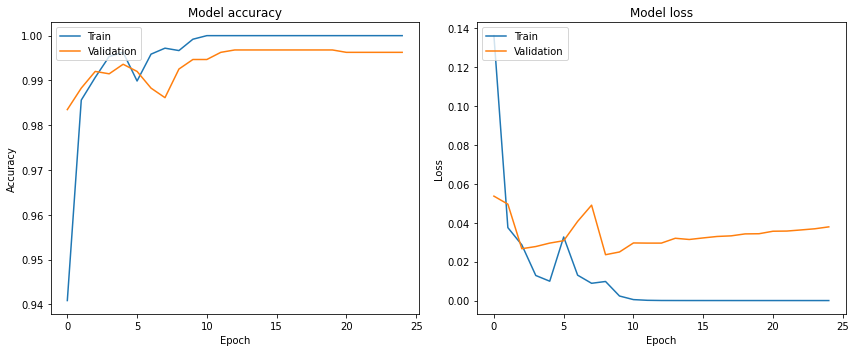

In [142]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

The CNN model achieves an impressive 100% training accuracy by Epoch 11, indicating a perfect fit to the training data. Concurrently, validation accuracy remains consistently above 98%, peaking at 99.68%. However, signs of overfitting emerge as the training loss dwindles towards zero, while the validation loss stabilizes and then experiences a minor increase. This suggests that 25 epochs might be excessive, as optimal performance is reached earlier, hinting that training could potentially cease after the 11th epoch to conserve resources without compromising performance.

In [146]:
# Using the model to predict on validation data
y_pred = model_cnn.predict(X_val)
# Convert the predictions to binary labels (0 or 1)
y_pred_binary = [1 if y[0] > 0.5 else 0 for y in y_pred]


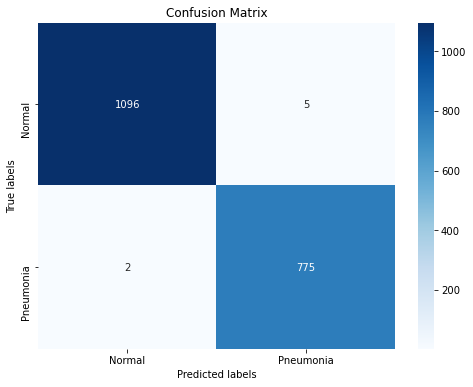

In [148]:
confusion = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The convolutional neural network (CNN) model exhibits remarkable proficiency in diagnosing pneumonia, correctly identifying 775 actual cases and 1096 non-pneumonia instances. Notably, it made only minor errors, misclassifying 5 normal cases as pneumonia (false positives) and overlooking just 2 actual pneumonia cases (false negatives). Such a high level of accuracy, especially in limiting false negatives, is crucial for medical applications to ensure disease cases are not missed, thereby showcasing the model's potential for clinical adoption.

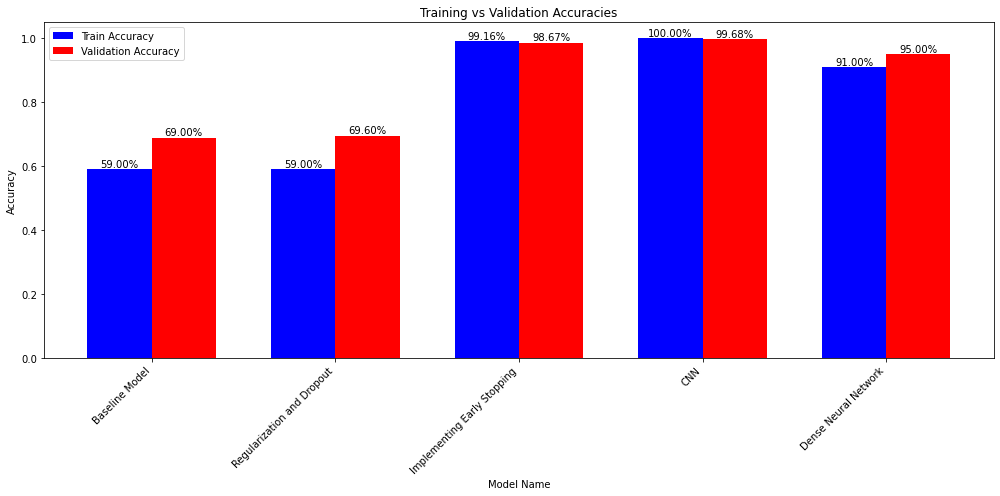

In [22]:
models = ['Baseline Model', 'Regularization and Dropout', 'Implementing Early Stopping', 'CNN', 'Dense Neural Network']

train_accuracies = [0.59, 0.59, 0.9916, 1.0, 0.91]
validation_accuracies = [0.69, 0.696, 0.9867, 0.9968, 0.95]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14,7))
bar1 = plt.bar(index, train_accuracies, bar_width, label='Train Accuracy', color='b')
bar2 = plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color='r')

# Label with the specific percentage values
def label_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % (height*100) + '%',
                ha='center', va='bottom')

label_bars(bar1)
label_bars(bar2)

plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right')  # Place the model names in the center of the grouped bars
plt.legend()
plt.tight_layout()
plt.show()

#### The Model

After evaluating the efficacy of 5 models for interpreting pneumonia x-ray images, the Convolutional Neural Network (CNN) emerges as the standout choice, evidenced by its superior accuracy on the validation set. The CNN's inherent ability to capture intricate patterns and hierarchical features in images lends it particularly suited for detailed analyses, such as those required by x-ray interpretation. As a next step, optimizing the CNN further can be achieved through hyperparameter tuning, employing methods like grid search. This would not only refine the model's performance but also bolster its capability to deliver more accurate and reliable interpretations of x-ray images.